In [1]:
from regression_toolbox.model import Model, add_model, delete_model
from regression_toolbox.likelihood import Likelihood
from regression_toolbox.parameter import Parameter
from visualisation_toolbox.domain import Domain
from regression_toolbox.sampler import Sampler
from visualisation_toolbox.visualiser import Visualiser
from data_processing.sim_data_processor import SimDataProcessor
from data_processing.raw_data_processor import RawDataProcessor
from gaussian_process_toolbox.kernel import Kernel
from gaussian_process_toolbox.gaussian_processor import GP
import numpy as np
import pandas as pd
import os
import jax

os.chdir('/PhD_project/')

jax.config.update("jax_enable_x64", True)


/build/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# report_title = ''

# # sim_model = Model('log_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('I_y',0.04).add_fixed_model_param('I_z',0.0016).add_fixed_model_param('Q',3.41e13)
# # sim_domain = Domain('cone_from_source_z_limited').add_domain_param('r',1000).add_domain_param('theta',np.pi/8).add_domain_param('source', [0,0,5]).add_domain_param('resolution',20)

# # sim_data_processor = SimDataProcessor('F_log_gaus_noise_pn_10', sim_model, sim_domain,noise_dist='gaussian' ,noise_percentage=0.1)

# processor_params = {
#     'output_header': 'counts',
#     'identifier':'aves',
#     'tax_group': 'class',
#     'num_x_cells': 10,
#     'num_y_cells': 10,
#     'timestep': 'year'
# }

# raw_data_processor = RawDataProcessor('xylo_test_project', 
#                                       'xylo_test_aves', 
#                                       'XYLO_processor', 
#                                       processor_params=processor_params)

# raw_data_processor.process_data()


# # model = Model('log_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('Q',3.41e13)
# # # likelihood = Likelihood('gaussian_percentage_error')
# # likelihood = Likelihood('gaussian')
# # # I_y_and_I_z = Parameter(name=['I_y','I_z'],prior_select='log_norm', multi_mode=True).add_prior_param('peak',  [[0.22,0.2],[0.16,0.12],[0.11,0.08],[0.08,0.06], [0.06,0.03], [0.04,0.016]] ).add_prior_param('overall_scale', 1)
# # # I_y = Parameter(name='I_y',prior_select='log_norm', multi_mode=True).add_prior_param('peak',  [0.22,0.16,0.11,0.08,0.06,0.04] ).add_prior_param('overall_scale', 5)
# # # I_z = Parameter(name='I_z',prior_select='log_norm', multi_mode=True).add_prior_param('peak',  [0.2,0.12,0.08,0.06,0.03,0.016] ).add_prior_param('overall_scale', 5)

# # I_y = Parameter(name='I_y',prior_select='uniform').add_prior_param('low',  0.0001).add_prior_param('high', 1)
# # I_z = Parameter(name='I_z',prior_select='uniform').add_prior_param('low',  0.0001).add_prior_param('high', 1)

# # # I_y_and_I_z = Parameter(name=['I_y','I_z'],prior_select='log_norm').add_prior_param('peak', [0.11,0.11] ).add_prior_param('scale',[[1,0],[0,1]])
# # # Q = Parameter(name='Q',prior_select='log_norm', order = 13).add_prior_param('peak',  1).add_prior_param('scale', 0.001)
# # # sigma = Parameter(name='sigma',prior_select='log_norm').add_prior_param('peak',  1).add_prior_param('scale', 1)
# # # sigma = Parameter(name='sigma',prior_select='uniform').add_prior_param('low',  0.0001).add_prior_param('high', 5)
# # sigma = Parameter(name='sigma',prior_select='uniform').add_prior_param('low',  0.0001).add_prior_param('high', 5)
# # error = Parameter(name='error',prior_select='uniform').add_prior_param('low',  0.0001).add_prior_param('high', 1)
# # # error = Parameter(name='error',prior_select='log_norm').add_prior_param('peak',  0.8).add_prior_param('scale', 0.00001)
# # # inference_params = pd.Series({'I_y_and_I_z': I_y_and_I_z, 'sigma':sigma})
# # # inference_params = pd.Series({'I_y_and_I_z': I_y_and_I_z, 'error':error})
# # # inference_params = pd.Series({'I_y_and_I_z': I_y_and_I_z})
# # # inference_params = pd.Series({'I_y': I_y, 'I_z': I_z, 'error':error})
# # inference_params = pd.Series({'I_y': I_y, 'I_z': I_z, 'sigma':sigma})


# # # sampler = Sampler(inference_params, model, likelihood, sim_data_processor, n_samples = 10000, n_chains=3)
# # sampler = Sampler(inference_params, model, likelihood, raw_data_processor, n_samples = 10000, n_chains=3)
# # sampler.sample_all()

# # visualiser = Visualiser(sampler)
# # visualiser.get_traceplots()

# # domain = Domain('cone_from_source_z_limited').add_domain_param('r',1000).add_domain_param('theta',np.pi/8).add_domain_param('source', [0,0,1]).add_domain_param('resolution',40)
# # domain.add_domain_param('z_slice', 0)
# # domain.add_domain_param('y_slice', 0)
# # domain.add_domain_param('x_slice', 100)

# # # visualiser.show_predictions(domain, 'test', title = 'Concentration of Droplets', plot_type='3D')
# # # visualiser.show_predictions(domain, 'test', title = 'Concentration of Droplets', plot_type='2D_slice')
# # visualiser.get_autocorrelations()
# # visualiser.get_summary()

# # Q_ref = {
# #             'vals' : [2.82e13, 3.11e13, 2.89e13, 4.83e13],
# #             'labels': ['250m','200m','750m','1000m'] 
# #         }

# # I_y_and_I_z_ref = {
# #             'vals' : [[0.22,0.2],[0.16,0.12],[0.11,0.08],[0.08,0.06], [0.06,0.03], [0.04,0.016]],
# #             'labels': ['A','B','C','D','E','F'] 
# #         }

# # I_y_ref = {
# #             'vals' : [0.22,0.16,0.11,0.08,0.06,0.04],
# #             'labels': ['A','B','C','D','E','F'] 
# #         }

# # I_z_ref = {'vals' : [0.2,0.12,0.08,0.06,0.03,0.016],
# #             'labels': ['A','B','C','D','E','F'] 
# #         }

# # visualiser.plot_prior('sigma', [0.0001,5])
# # # visualiser.plot_prior('error', [0,1])
# # # visualiser.plot_prior('I_y_and_I_z', [[0.0001,0.3],[0.0001,0.3]], I_y_and_I_z_ref)

# # visualiser.plot_prior('I_y', [0.0001,0.5], I_y_ref)
# # visualiser.plot_prior('I_z', [0.0001,0.5], I_z_ref)

# # visualiser.plot_posterior('sigma', [0.0001,5])
# # # visualiser.plot_posterior('error', [0,1])
# # # visualiser.plot_posterior('I_y_and_I_z', [[0.0001,0.3],[0.0001,0.3]], I_y_and_I_z_ref)

# # visualiser.plot_posterior('I_y', [0.0001,0.5], I_y_ref)
# # visualiser.plot_posterior('I_z', [0.0001,0.5], I_z_ref)

# # visualiser.generate_report(report_title)
# # visualiser.embed_report()


In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from app.gaussian_process_toolbox.kernel import Kernel

# Define a spatiotemporal kernel configuration
kernel_config = {
    ('matern', 'xy'): [0, 1],  # Apply Matern kernel to spatial dimensions (latitude, longitude)
    ('rbf', 't'): [2]          # Apply RBF kernel to temporal dimension (time)
}

# Create kernel instance
kernel_obj = Kernel(kernel_config, kernel_concatination='*')

# Set kernel parameters
kernel_obj.add_kernel_param('matern', 'xy', 'length_scale', [1.5, 1.5])
kernel_obj.add_kernel_param('matern', 'xy', 'nu', 1.5)  # Smoothness parameter
kernel_obj.add_kernel_param('rbf', 't', 'length_scale', 2.0)

# Retrieve the kernel
gp_kernel = kernel_obj.get_kernel()

# Generate synthetic training data: 50 samples in (latitude, longitude, time)
X_train = np.random.rand(50, 3)
y_train = np.sin(X_train[:, 0]) + np.cos(X_train[:, 1]) + 0.1 * X_train[:, 2]

# Fit a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

# Predict on new data
X_test = np.random.rand(5, 3)
y_pred, y_std = gp.predict(X_test, return_std=True)

print("Predictions:", y_pred)
print("Prediction Standard Deviations:", y_std)
print("Optimized Kernel:", gp.kernel_)


Predictions: [1.18741268 1.57638967 1.40934353 1.65500127 1.53031579]
Prediction Standard Deviations: [0.00084349 0.00148696 0.00529457 0.00175217 0.00242193]
Optimized Kernel: _KernelTransformer(2.22, 2.09) * _KernelTransformer(3.03)


In [4]:
# Define a multi-Matern kernel configuration
kernel_config = {
    ('matern', 'spatial'): [0, 1],  # Matern kernel for depth and distance
    ('matern', 'temporal'): [2]     # Separate Matern kernel for time
}

# Create kernel instance
kernel_obj = Kernel(kernel_config, kernel_concatination='*')

# Set kernel parameters
kernel_obj.add_kernel_param('matern', 'spatial', 'length_scale', [3.0, 3.0])
kernel_obj.add_kernel_param('matern', 'spatial', 'nu', 0.5)  # Rougher process
kernel_obj.add_kernel_param('matern', 'temporal', 'length_scale', 5.0)
kernel_obj.add_kernel_param('matern', 'temporal', 'nu', 1.5)  # Smoother process

# Retrieve the kernel
gp_kernel = kernel_obj.get_kernel()

# Generate synthetic training data: 100 samples (depth, distance, time)
X_train = np.random.rand(100, 3)
y_train = np.sin(X_train[:, 0]) * np.cos(X_train[:, 1]) + 0.2 * X_train[:, 2]

# Fit Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

# Predict on new data
X_test = np.random.rand(10, 3)
y_pred, y_std = gp.predict(X_test, return_std=True)

print("Predictions:", y_pred)
print("Prediction Standard Deviations:", y_std)
print("Optimized Kernel:", gp.kernel_)


Predictions: [0.45686443 0.73981148 0.63387843 0.56947396 0.53661657 0.76177953
 0.3432892  0.39724841 0.73923617 0.83273436]
Prediction Standard Deviations: [0.01311218 0.01155852 0.00986673 0.00310952 0.01600721 0.01130627
 0.01402515 0.01193581 0.01279467 0.01644231]
Optimized Kernel: _KernelTransformer(5.32, 6.14) * _KernelTransformer(2.82)


Constructed Kernel: _KernelTransformer(0.405) + _KernelTransformer(0)
Predictions: [ 0.22018046  0.28812004  0.35777501  0.42824754  0.49857245  0.56773333
  0.63468056  0.69835101  0.75768875  0.81166644  0.85930667  0.89970294
  0.93203935  0.95560878  0.96982889  0.97425541  0.96859253  0.9526999
  0.92659611  0.89045854  0.84461961  0.78955946  0.72589542  0.65436837
  0.57582664  0.49120778  0.40151867  0.30781473  0.21117867  0.11269931
  0.01345128 -0.08552422 -0.18323687 -0.2787626  -0.37125662 -0.45996377
 -0.54422621 -0.62348821 -0.69729833 -0.76530893 -0.82727337 -0.88304096
 -0.93255029 -0.97582097 -1.01294436 -1.04407364 -1.06941346 -1.08920969
 -1.10373948 -1.11330187]
Prediction Standard Deviations: [0.14210455 0.12884125 0.11844701 0.11067566 0.10515262 0.10142391
 0.09902339 0.09753301 0.09661868 0.09603968 0.09563934 0.09532684
 0.09505721 0.09481369 0.09459414 0.09440198 0.09424107 0.09411382
 0.09402127 0.09396425 0.09394453 0.09396546 0.09403176 0.09414854
 0.09431

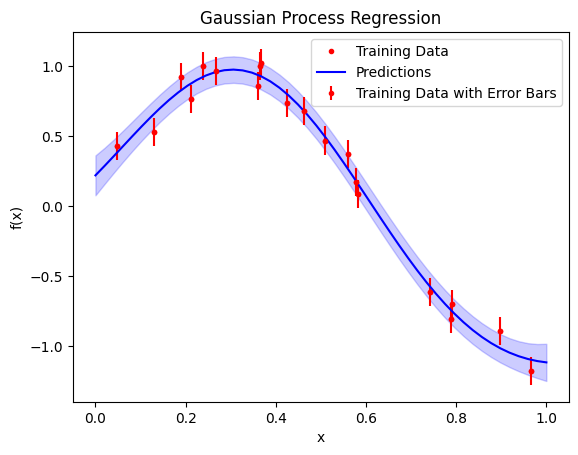

In [5]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor

# Define kernel configuration for a single RBF kernel applied to 'x' (dimension index 0)
kernel_config = {('rbf', 'x'): [0],
                 ('white', 'x'): [0]}

# Create kernel instance
kernel_obj = Kernel(kernel_config)

# Set kernel parameters
kernel_obj.add_kernel_param('rbf', 'x', 'length_scale', 1.5)

# Retrieve the kernel
gp_kernel = kernel_obj.get_kernel()
print(f"Constructed Kernel: {gp_kernel}")

# Generate synthetic training data
X_train = np.random.rand(20, 1)  # 20 samples, 1D input (since we're using only 'x')
# Generate synthetic training data with noise
y_train = np.sin(5 * X_train).flatten() + 0.1 * np.random.randn(20)

# Fit a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

# Predict on new data
X_test = np.linspace(0, 1, 50).reshape(-1, 1)  # 50 test points
y_pred, y_std = gp.predict(X_test, return_std=True)

# Print results
print("Predictions:", y_pred)
print("Prediction Standard Deviations:", y_std)
print("Optimized Kernel:", gp.kernel_)


plt.figure()
plt.plot(X_train, y_train, 'r.', label='Training Data')
plt.errorbar(X_train, y_train, yerr=0.1, fmt='r.', label='Training Data with Error Bars')
plt.plot(X_test, y_pred, 'b-', label='Predictions')
plt.fill_between(X_test.flatten(), y_pred - y_std, y_pred + y_std, alpha=0.2, color='blue')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()


Data loaded from /PhD_project/data/processed_sim_data/gp_test_4
{'fitted_kernel_params': {'type': 'Sum', 'operation': 'Sum', 'sub_kernels': [{'type': '_KernelTransformer', 'dims': [0], 'base_kernel': {'type': 'RBF', 'parameters': {'length_scale': 1.6054461305104906, 'length_scale_bounds': '(1e-05, 100000.0)'}}}, {'type': '_KernelTransformer', 'dims': [0], 'base_kernel': {'type': 'WhiteKernel', 'parameters': {'noise_level': 0.0036329484265271864, 'noise_level_bounds': '(1e-05, 100000.0)'}}}]}, 'training_r2': 0.9983190389266206, 'testing_r2': 0.9917200995209426}
Predictions: [ 6.13511094  6.72268662  7.29083819  7.84699868  8.39699536  8.94278055
  9.48091021 10.00202274 10.4913952  10.93047129 11.29909733 11.57809618
 11.75177209 11.80997203 11.74942226 11.57418994 11.29526305 10.92937196
 10.49727174 10.02175483  9.52566634  9.03015551  8.55333044  8.10940304
  7.70833379  7.35592129  7.05423844  6.80229601  6.59681466  6.43300204
  6.30525686  6.20775076  6.13486599  6.08148886  6.043

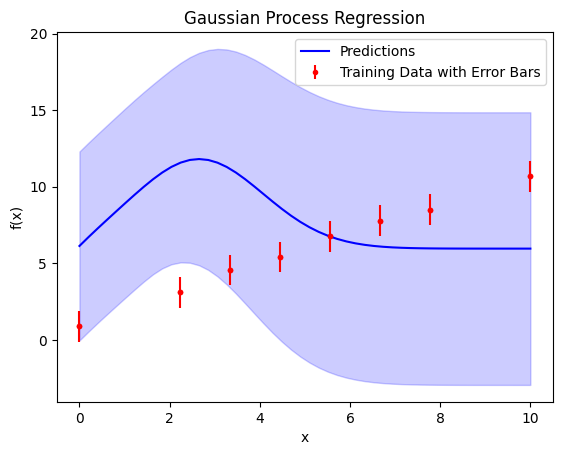

In [ ]:
sim_model = Model('line').add_fixed_model_param('a', 1).add_fixed_model_param('b', 1)
sim_domain = Domain(1, 'linear').add_domain_param('min', 0).add_domain_param('max', 10).add_domain_param('n_points', 10)
sim_domain.build_domain()
sim_data_processor = SimDataProcessor('gp_test_4', sim_model, sim_domain,noise_dist='gaussian' ,noise_level=.5)

# Define kernel configuration for a single RBF kernel applied to 'x' (dimension index 0)
kernel_config = {('rbf', 'x'): [0],
                 ('white', 'x'): [0]}

# Create kernel instance
kernel_obj = Kernel(kernel_config).add_kernel_param('rbf', 'x', 'length_scale', 0.1)

gp = GP(sim_data_processor, kernel_obj)
gp_model = gp.train()

vis_domain = Domain(1, 'linear').add_domain_param('min', 0).add_domain_param('max', 10).add_domain_param('n_points', 1000)
vis_domain.build_domain()

# Now I have to automate this bit 

# Predict on new data
X_test = np.linspace(0, 10, 50).reshape(-1, 1)  # 50 test points
y_pred, y_std = gp.predict(X_test)

# Print results
print("Predictions:", y_pred)
print("Prediction Standard Deviations:", y_std)

X_train = gp.X_train
y_train = gp.y_train

plt.figure()
plt.plot(X_train, y_train, 'r.')
plt.errorbar(X_train, y_train, yerr=1, fmt='r.', label='Training Data with Error Bars')
plt.plot(X_test, y_pred, 'b-', label='Predictions')
plt.fill_between(X_test.flatten(), y_pred - y_std, y_pred + y_std, alpha=0.2, color='blue')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()

